In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

from mcmcmd.samplers import *
from mcmcmd.tests import *

# Helper functions

In [100]:

'''
Generate PP plots for beta
'''
def pp_plots_beta(marginal_samples_beta, successive_samples_beta):
    assert marginal_samples_beta.shape[1] == successive_samples_beta.shape[1]
    pp_step_size = 0.01 # plot every percentile
    p = marginal_samples_beta.shape[1]
    labels = [rf'$\beta_{i}$' for i in range(1,p+1)]

    x_pp = geweke_functions(marginal_samples_beta)
    y_pp = geweke_functions(successive_samples_beta)
    dim_grid = p

    # Check distributions of samples
    x_pp_1 = x_pp[:, :p]
    y_pp_1 = y_pp[:, :p]

    for j in range(dim_grid):
        plt.subplot(dim_grid, dim_grid, j+1)
        plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=False, labelbottom=True)
        prob_plot(x_pp_1[:, j], y_pp_1[:, j], step=pp_step_size)
        plt.title(labels[j])
        if j==0:
            plt.tick_params(left=True, labelleft=True)
    plt.show()

    # Check distributions of sample cross-products
    x_pp_2 = x_pp[:, p:]
    y_pp_2 = y_pp[:, p:]
    theta2_count = int(p*(p+1)/2)

    ind_plot = 0
    ind_xlabel = 0
    ind_ylabel = 0
    for j in range(dim_grid**2):
        pos_hor = j % dim_grid + 1
        pos_vert = j // dim_grid + 1
        if pos_hor <= pos_vert:
            plt.subplot(dim_grid, dim_grid, j+1)
            plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            prob_plot(x_pp_2[:, ind_plot], y_pp_2[:, ind_plot], step=pp_step_size)
            ind_plot += 1
        if pos_hor == 1:
            plt.ylabel(labels[ind_ylabel])
            ind_ylabel += 1
            plt.tick_params(left=True, labelleft=True)
        if pos_vert == dim_grid:
            plt.xlabel(labels[ind_xlabel])
            ind_xlabel += 1
            plt.tick_params(bottom=True, labelbottom=True)
    plt.show()

'''
RJ Bayesian Lasso model based on (Chen, Wang, and McKeown 2011), with approximate sampling method from (Korattikara, Chen, and Welling 2014)
'''
class bayes_lasso_sampler(model_sampler):
    def __init__(self, **kwargs):
      self._mode = 'exact'
      super().__init__(**kwargs)

      # Check inputs
      for attr in ['_n', '_p', '_Lambda', '_tau', '_sigma', '_epsilon_update', '_epsilon_birth']:
          assert hasattr(self, attr)
      self._n = int(self._n)
      self._p = int(self._p)
      assert onp.all(onp.array([self._n, self._p, self._Lambda, self._tau,
                                self._sigma, self._epsilon_update, self._epsilon_birth]) > 0)
      assert self._mode in ('exact', 'approx')
      if self._mode == 'approx':
        assert hasattr(self, '_epsilon_approx')
        assert hasattr(self, '_batch_size')
        assert onp.all(onp.array([self._epsilon_approx, self._batch_size]) > 0)
      pass

    @property
    def sample_dim(self):
      # y + beta
      return self._n + self._p

    @property
    def theta_indices(self):
      return onp.arange(self._n, self._n + self._p)

    def log_prior(self, beta=None, gamma=None, k=None):
      if beta is None:
        beta = self._beta
      if gamma is None:
        gamma = self._gamma
      if k is None:
        k = self._k
      return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k+1) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum()

    def log_likelihood(self, beta=None, subset=None, return_components=False):
      if beta is None:
        beta = self._beta
      if subset is None:
        subset = onp.arange(self._n)
      l = norm.logpdf(x=self._y[subset, :],
                      loc=self._X[subset, :]@beta, scale=self._sigma)
      if return_components == False:
        l = l.sum()
      return l

    def log_joint(self, beta=None, gamma=None, k=None):
      if beta is None:
        beta = self._beta
      if gamma is None:
        gamma = self._gamma
      if k is None:
        k = self._k
      l_prior = self.log_prior(beta=beta, gamma=gamma, k=k)
      l_likelihood = self.log_likelihood(beta=beta)
      return l_prior + l_likelihood

    def drawData(self, rng=None):
      if rng is None:
          rng = self._rng_s

      self._X = rng.normal(size=[self._n, self._p])
      self._p_k = onp.exp(onp.arange(1, self._p+1) * onp.log(self._Lambda) -
                          self._Lambda - loggamma(1+onp.arange(1, self._p+1)))
      self._p_k = self._p_k/self._p_k.sum()
      pass

    def drawPrior(self, rng=None):
      if rng is None:
          rng = self._rng_s

      self._beta = onp.zeros(shape=[self._p, 1])
      self._k = rng.choice(a=onp.arange(1, self._p+1), p=self._p_k)

      self._gamma = rng.choice(self._p, size=self._k, replace=False)
      self._beta[self._gamma, :] = rng.laplace(
          scale=self._tau, size=[self._k, 1])
      return self._beta.flatten()

    def drawLikelihood(self, rng=None):
      if rng is None:
          rng = self._rng_s

      self._y = rng.normal(loc=self._X @ self._beta,
                           scale=self._sigma).reshape(self._n, 1)
      return self._y.flatten()

    def drawPosterior(self, rng=None):
      if rng is None:
          rng = self._rng_s

      j, k_proposal, gamma_proposal, beta_proposal = self.getProposal(rng)

      if self._mode == 'exact':
        self.updateMH(j, k_proposal, gamma_proposal, beta_proposal, rng)
      elif self._mode == 'approx':
        self.updateApproxMH(j, k_proposal, gamma_proposal, beta_proposal, rng)

      return self._beta.flatten()

    def getProposal(self, rng):
      beta_proposal = self._beta.copy()
      if self._p == 1:
        k_proposal = self._k
      elif self._k == 1:
        k_proposal = self._k + rng.choice([0, 1])
      elif self._k == self._p:
        k_proposal = self._k + rng.choice([-1, 0])
      else:
        k_proposal = self._k + rng.choice([-1, 0, 1])

      if k_proposal == self._k:  # update
        j = rng.choice(self._gamma)
        gamma_proposal = self._gamma
        beta_proposal[j, :] += rng.normal(scale=self._epsilon_update)
      elif k_proposal == self._k + 1:  # birth
        j = rng.choice(onp.setdiff1d(onp.arange(self._p), self._gamma))
        gamma_proposal = onp.hstack([self._gamma, j])
        beta_proposal[j, :] = rng.normal(scale=self._epsilon_birth)
      elif k_proposal == self._k - 1:  # death
        j = rng.choice(self._gamma)
        gamma_proposal = self._gamma[self._gamma != j]
        beta_proposal[j, :] = 0.
      return j, k_proposal, gamma_proposal, beta_proposal

    # Calculate p(gamma -> gamma_proposal)
    def gammaProposal_prob(self, gamma, gamma_proposal):
      k = gamma.shape[0]
      k_proposal = gamma_proposal.shape[0]
      prob = 0.
      if self._p == 1:
        return prob
      if k == 1 and onp.intersect1d(gamma, gamma_proposal).shape[0] == 1:
        if k_proposal == k+1:
          prob = 0.5 * 1./(self._p - k)
        elif k_proposal == k:
          prob = 0.5
      elif 1 < k and k < self._p and onp.abs(onp.intersect1d(gamma, gamma_proposal).shape[0] - k) <= 1:
        if k_proposal == k+1:
          prob = 1./3. * 1./(self._p - k)
        elif k_proposal == k:
          prob = 1./3.
        elif k_proposal == k-1:
          prob = 1./3. * 1./k
      elif k == self._p and onp.intersect1d(gamma, gamma_proposal).shape[0] == self._p-1:
        if k_proposal == k:
          prob = 0.5
        elif k_proposal == k-1:
          prob = 0.5 * 1./k
      return prob

    # Metropolis-Hastings update
    def updateMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
      if k_proposal == self._k:  # update
        MH_augment = 0.
      elif k_proposal == self._k + 1:  # birth
        MH_augment = onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) - onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) - float(norm.logpdf(beta_proposal[j, :], scale=self._epsilon_birth))
      elif k_proposal == self._k - 1:  # death
        MH_augment = onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) - onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) + float(norm.logpdf(self._beta[j, :], scale=self._epsilon_birth))

      diff_log_joint = self.log_joint(
          beta=beta_proposal, gamma=gamma_proposal, k=k_proposal) - self.log_joint()
      threshold = diff_log_joint + MH_augment

      log_u = onp.log(rng.uniform())
      if log_u <= threshold:
        self._k = k_proposal
        self._gamma = gamma_proposal
        self._beta = beta_proposal
      return log_u, threshold

    # Approximate Metropolis-Hastings update
    def updateApproxMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
      # Calculate threshold
      u = rng.uniform()
      if k_proposal == self._k:  # update
        MH_augment = 0.
      elif k_proposal == self._k + 1:  # birth
        MH_augment = -onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) + onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) + float(norm.logpdf(beta_proposal[j, :], scale=self._epsilon_birth))
      elif k_proposal == self._k - 1:  # death
        MH_augment = -onp.log(self.gammaProposal_prob(gamma_proposal, self._gamma)) + onp.log(self.gammaProposal_prob(
            self._gamma, gamma_proposal)) - float(norm.logpdf(self._beta[j, :], scale=self._epsilon_birth))

      threshold = (onp.log(u) + self.log_prior() - self.log_prior(beta=beta_proposal,
                                                                  gamma=gamma_proposal, k=k_proposal) + MH_augment)/self._n

      l = 0
      l2 = 0
      sample = onp.array([])
      sample_size = 0
      permutation = rng.permutation(self._n)
      done = False

      while not done:
        batch_size = min(self._batch_size, self._n - sample_size)
        batch = permutation[sample_size:(sample_size+batch_size)]
        sample = onp.hstack([sample, batch])

        l_diff = self.log_likelihood(beta=beta_proposal, subset=batch, return_components=True) - \
            self.log_likelihood(subset=batch, return_components=True)
        l += l_diff.sum()
        l2 += (l_diff**2).sum()

        sample_size += batch_size

        l_sd = onp.sqrt((l2/sample_size - (l/sample_size)**2)
                        * sample_size/(sample_size-1))
        l_se = l_sd/onp.sqrt(sample_size) * onp.sqrt(1 -
                                                     (sample_size-1)/(self._n-1))

        if l_se > 0:
          test_stat = onp.abs(l-threshold)/l_se
          delta = 1 - t.cdf(test_stat, sample_size-1)
        else:
          delta = 0
        if delta <= self._epsilon_approx:
          if l >= threshold:
            self._k = k_proposal
            self._gamma = gamma_proposal
            self._beta = beta_proposal
          done = True
      pass

'''
Generate samples and test them for a bayes_lasso_sampler
'''
def sample_and_test(bayes_lasso):
    bayes_lasso.drawData() # set X
    marginal_samples = bayes_lasso.sample_mc(num_samples)

    marginal_samples_beta = marginal_samples[:, bayes_lasso.theta_indices]
    marginal_samples_gamma = (marginal_samples_beta!=0).astype('int')
    marginal_samples_k = marginal_samples_gamma.sum(1)

    successive_samples = bayes_lasso.sample_sc(num_samples)
    successive_samples_beta = successive_samples[:, bayes_lasso.theta_indices]
    successive_samples_gamma = (successive_samples_beta!=0).astype('int')
    successive_samples_k = successive_samples_gamma.sum(1)

    backward_samples = bayes_lasso.sample_bc(1e3, burn_in_samples=10)
    backward_samples_beta = backward_samples[:, bayes_lasso.theta_indices]
    backward_samples_gamma = (backward_samples_beta!=0).astype('int')
    backward_samples_k = backward_samples_gamma.sum(1)

    print('Geweke test')
    time_start = perf_counter()
    print(geweke_test(geweke_functions(marginal_samples_beta), geweke_functions(successive_samples_beta), l=0.08, alpha=0.05))
    time_end = perf_counter()
    time_geweke = onp.round(time_end - time_start, 3)
    print(f'Test time: {time_geweke} seconds')

    print('Wild bootstrap MMD test')
    thinned_samples_mmd = onp.arange(0, num_samples, int(num_samples/1000)).astype('int') # thinning for MMD tests
    time_start = perf_counter()
    f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)
    print(mmd_wb_test(marginal_samples_beta[thinned_samples_mmd, :], successive_samples_beta[thinned_samples_mmd, :], f_kernel, alpha=0.05))
    time_end = perf_counter()
    time_wild = onp.round(time_end - time_start, 3)
    print(f'Test time: {time_wild} seconds')

    print('Backward MMD test')
    time_start = perf_counter()
    print(mmd_test(marginal_samples_beta[thinned_samples_mmd, :], backward_samples_beta, sg.GaussianKernel(10,1), alpha=0.05))
    time_end = perf_counter()
    time_backward = onp.round(time_end - time_start, 3)
    print(f'Test time: {time_backward} seconds')

    pp_plots_beta(marginal_samples_beta, successive_samples_beta)
    plt.show()

# Model

Given the multivariate linear regression model

\begin{equation}
  \mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
\end{equation}

\begin{equation}
  \mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^{2} \mathbf{I})
\end{equation}

In standard Lasso, we would introduce an L1 penalty to the objective function with a corresponding regularization parameter. Here, we instead promote sparsity by placing a (truncated) Poisson prior on the number $k$ of nonzero coefficients $\beta_{j}$ and drawing these coefficients from a Laplace distribution. Define the parameters $\mathbf{\Theta} = \{\lambda, \sigma, \tau, k, \mathbf{\gamma}, \mathbf{\beta}\}$ such that

\begin{equation}
  p(\mathbf{\Theta}) = p(k|\lambda) p(\mathbf{\gamma}|k) p(\beta_{j} | \tau, \gamma )
\end{equation}

\begin{equation}
  p(k|\lambda) = \frac{\exp{(-\lambda)} \lambda^{k}}{Ck!}, \quad k \in \{1,\ldots, p\}
\end{equation}
\begin{equation}
  p(\mathbf{\gamma}|k) = {p\choose k}^{-1}
\end{equation}

\begin{equation}
  p(\beta_{j} | \tau, \gamma ) = \begin{cases} (2\tau)^{-1}\exp(-\frac{|\beta_{j}|}{\tau}) & j \in \mathbf{\gamma} \\ \delta(\beta_{j}) & \text{otherwise} \end{cases}
\end{equation}

where $C$ is a normalization constant, $\delta$ is the Dirac delta function, and $\mathbf{\gamma}$ is a vector of the nonzero indices of $\mathbf{\beta}$.

The likelihood is given by

\begin{equation}
  p(\mathbf{y} | \sigma, \mathbf{\beta} ) = (2\pi)^{-\frac{n}{2}} \sigma^{-n} \exp{(-\frac{\Vert\mathbf{y}-\mathbf{X}\mathbf{\beta}\Vert^{2}_{2}}{2\sigma^{2}})}
\end{equation}

Here, $\{\lambda, \sigma, \tau\}$ are fixed, but we could place priors on them, e.g., inverse-gamma (TODO?).

Then
\begin{equation}
 p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} ) \propto \sigma^{-n} \exp{(-\frac{\Vert\mathbf{y}-\mathbf{X}\mathbf{\beta}\Vert^{2}_{2}}{2\sigma^{2}})} \frac{\exp{(-\lambda)} \lambda^{k}}{k!} {p\choose k}^{-1} \prod_{j\in \mathbf{\gamma}} (2\tau)^{-1}\exp(-\frac{|\beta_{j}|}{\tau}) \prod_{k \notin \mathbf{\gamma}} \delta(\beta_{k})
\end{equation}


The code for the `bayes_lasso_sampler` class is given in the Helper Functions section.

Now we will draw the marginal-conditional samples. The `sample_mc` function only returns $\{y_{i}, \mathbf{\beta}_{i}\}$, but it is easy to recover $\{k_{i}, \gamma_{i}\}$ if they are of interest.

In [5]:
n=3; p=3
Lambda=1; tau=1; sigma=1
epsilon_update=2; epsilon_birth=epsilon_update
num_samples = int(1e5)
nthreads = 4

In [83]:
bayes_lasso = bayes_lasso_sampler(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso.set_nthreads(nthreads)
bayes_lasso.drawData() # set X
marginal_samples = bayes_lasso.sample_mc(num_samples)

In [84]:
marginal_samples_beta = marginal_samples[:, bayes_lasso.theta_indices]
# marginal_samples_gamma = (marginal_samples_beta!=0).astype('int')
# marginal_samples_k = marginal_samples_gamma.sum(1)

Each iteration of the reversible-jump MCMC posterior sampler proposes $k' \in \{k-1, k, k+1\}$ uniformly at random, disallowing $k<1$ and $k>p$. Thus, when $k \in \{1,p\}$, there are only two valid proposals, not three. Depending on the $k'$ chosen and the random walk step sizes $\epsilon_{\text{update}}, \epsilon_{\text{birth}}$, one of the following moves are made.

- Update: $k' = k$
  - Choose $j \in \{1, \ldots, k\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma}, \beta'_{j} = \beta_{j} + \mathcal{N}(0, \epsilon_{\text{update}}), \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )}, 1)}$

- Birth: $k' = k+1$
  - Choose $j \in \{k+1, \ldots, p\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma} \cup j$
  - Propose $\beta'_{j} = \mathcal{N}(0, \epsilon_{\text{birth}}), \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )} \frac{p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta})}{p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}')}, 1)}$
  - The probability of the reverse jump is $p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta}) = \begin{cases}\frac{1}{2}\frac{1}{k'} & k'=p \\ \frac{1}{3} \frac{1}{k'} & 1<k<p \end{cases} $
  - The probability of the forward jump is $p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}') = \begin{cases}\frac{1}{2}\frac{1}{p-k} \mathcal{N}(\beta_{j}'; 0,\epsilon_{\text{birth}}) & k=1 \\ \frac{1}{3} \frac{1}{p-k} \mathcal{N}(\beta_{j}'; 0,\epsilon_{\text{birth}}) & 1<k<p \end{cases} $

- Death: $k' = k-1$
  - Choose $j \in \{1, \ldots, k\}$ uniformly at random
  - Propose $\mathbf{\gamma}' = \mathbf{\gamma} \setminus j$ 
  - Propose $\beta'_{j} = 0, \beta'_{i \neq j} = \beta_{i}$
  - Accept proposal $\mathbf{\Theta}'$ with probability $\min{(\frac{p(\mathbf{y}, \mathbf{\Theta'} | \mathbf{X} )}{p(\mathbf{y}, \mathbf{\Theta} | \mathbf{X} )} \frac{p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta})}{p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}')}, 1)}$
  - The probability of the reverse jump is $p(\mathbf{\Theta}' \rightarrow \mathbf{\Theta}) = \begin{cases}\frac{1}{2}\frac{1}{p-k'} \mathcal{N}(\beta_{j}; 0,\epsilon_{\text{birth}}) & k'=1 \\ \frac{1}{3} \frac{1}{p-k'} \mathcal{N}(\beta_{j}; 0,\epsilon_{\text{birth}}) & 1<k'<p \end{cases} $
  - The probability of the forward jump is $p(\mathbf{\Theta} \rightarrow \mathbf{\Theta}') = \begin{cases}\frac{1}{2}\frac{1}{k} & k=p \\ \frac{1}{3} \frac{1}{k} & 1<k<p \end{cases} $

Now we draw the successive-conditional samples and burned-in backward samples

In [85]:
successive_samples = bayes_lasso.sample_sc(num_samples)
successive_samples_beta = successive_samples[:, bayes_lasso.theta_indices]
successive_samples_gamma = (successive_samples_beta!=0).astype('int')
successive_samples_k = successive_samples_gamma.sum(1)

backward_samples = bayes_lasso.sample_bc(1e3, burn_in_samples=10)
backward_samples_beta = backward_samples[:, bayes_lasso.theta_indices]
# backward_samples_gamma = (backward_samples_beta!=0).astype('int')
# backward_samples_k = backward_samples_gamma.sum(1)

# Tests

To check the posterior sampler, we will first perform a Geweke test on the first and second empirical moments of the samples.

Notes on the code:
- `geweke_functions(S)` returns $[\mathbf{s}_{1}, \ldots, \mathbf{s}_{p}, \mathbf{s}_{1} \odot \mathbf{s}_{1}, \mathbf{s}_{1} \odot \mathbf{s}_{2}, \ldots, \mathbf{s}_{p} \odot \mathbf{s}_{p} ]$, where $\mathbf{s}_{j}$ is the $j^{\text{th}}$ column of $S$. The column means of the output are the first and second empirical moments of $\mathbf{S}$.
- The argument `l` to `geweke_test` controls the window size used to estimate the successive-conditional standard errors. Specifically, the window size is given by `l * num_samples`. 
- The argument `alpha` to `geweke_test` is the significance level of the tests.

In [87]:
time_start = perf_counter()
print(geweke_test(geweke_functions(marginal_samples_beta), geweke_functions(successive_samples_beta), l=0.08, alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': array([False, False,  True, False, False, False, False, False, False]), 'p_value': array([0.51173539, 0.08457038, 0.02580326, 0.23001847, 0.25809559,
       0.86144191, 0.18254005, 0.05210489, 0.19769923]), 'test_statistic': array([ 0.65613792, -1.72476198,  2.22916005,  1.20031127, -1.13090378,
       -0.17453897, -1.33297486,  1.94226616,  1.28813426]), 'critical_value': 1.959963984540054}
Test time: 27.718 seconds


Next, we can try the MMD tests. First, the wild bootstrap version:

In [88]:
thinned_samples_mmd = onp.arange(0, num_samples, int(num_samples/1000)).astype('int') # thinning for MMD tests; will use 1000 samples.
time_start = perf_counter()
f_kernel = lambda X, Y: rbf_kernel(X, Y, tau=1)
print(mmd_wb_test(marginal_samples_beta[thinned_samples_mmd, :], successive_samples_beta[thinned_samples_mmd, :], f_kernel, alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': False, 'p_value': 0.66, 'test_statistic': 1.1983315985756007, 'critical_value': 2.533462191737322}
Test time: 1.122 seconds


Next, the backward version:

In [89]:
time_start = perf_counter()
print(mmd_test(marginal_samples_beta[thinned_samples_mmd, :], backward_samples_beta, sg.GaussianKernel(10,1), alpha=0.05))
time_end = perf_counter()
print(f'Test time: {onp.round(time_end - time_start, 3)} seconds')

{'result': False, 'p_value': 0.836, 'test_statistic': -0.2704160287976265, 'critical_value': 0.5377397174015641, 'kernel_width': 1.0}
Test time: 7.927 seconds


All three tests fail to reject the null hypothesis that the distributions are the same. To confirm these results visually, we can examine the PP plots of the distributions of the (marginal-conditional and successive-conditional) samples and their cross-products. The closer the points are to the unit line, the better.

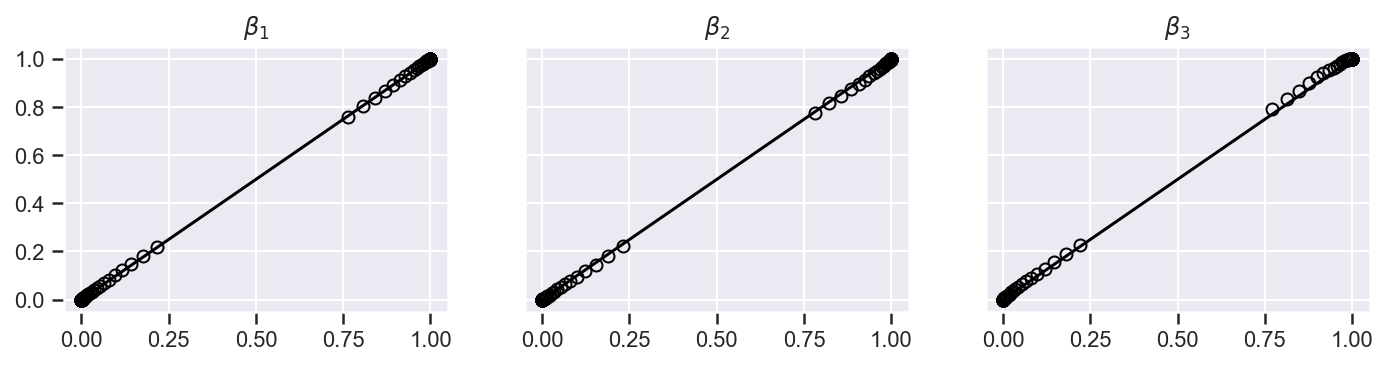

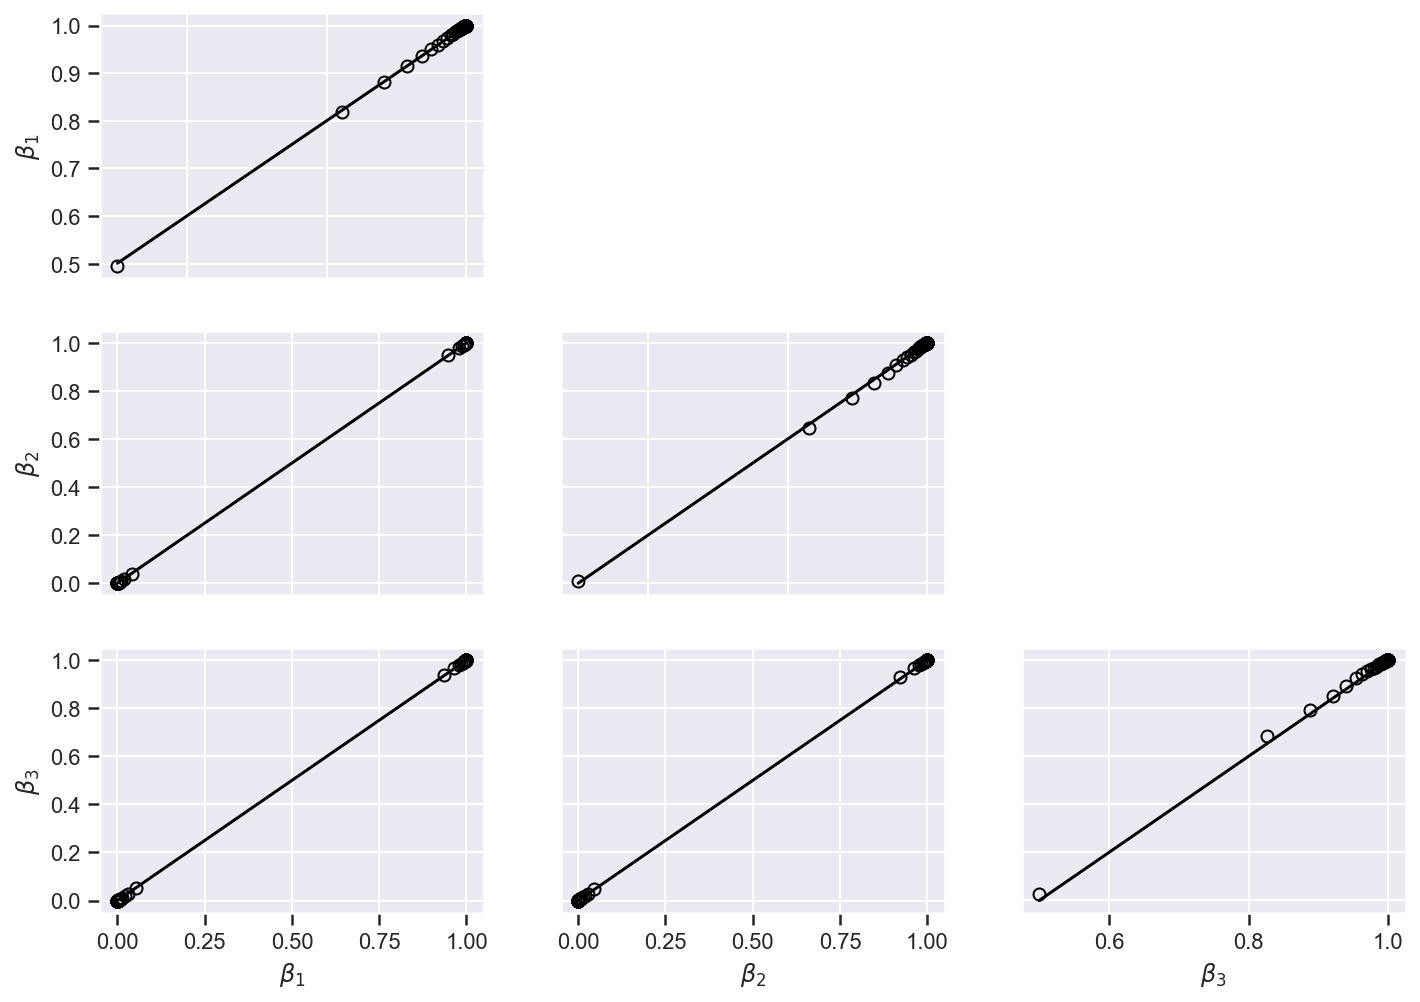

In [90]:
pp_plots_beta(marginal_samples_beta, successive_samples_beta)

Now, let's introduce intentional errors and see if the tests detect them.

Geweke test
{'result': array([False, False, False,  True, False,  True, False, False,  True]), 'p_value': array([1.07532167e-01, 8.99222793e-01, 9.79965790e-01, 1.32800726e-03,
       5.70223085e-01, 3.80685061e-06, 1.65289108e-01, 3.48523815e-01,
       7.10542736e-15]), 'test_statistic': array([ 1.60938507, -0.12664321, -0.0251118 ,  3.20985764, -0.56772298,
        4.62165809, -1.3875008 ,  0.93745645,  7.78275694]), 'critical_value': 1.959963984540054}
Test time: 29.507 seconds
Wild bootstrap MMD test
{'result': True, 'p_value': 0.0, 'test_statistic': 11.853276595615077, 'critical_value': 1.991477314387503}
Test time: 1.169 seconds
Backward MMD test
{'result': True, 'p_value': 0.01200000000000001, 'test_statistic': 0.75040094088763, 'critical_value': 0.5163562018424273, 'kernel_width': 1.0}
Test time: 7.934 seconds


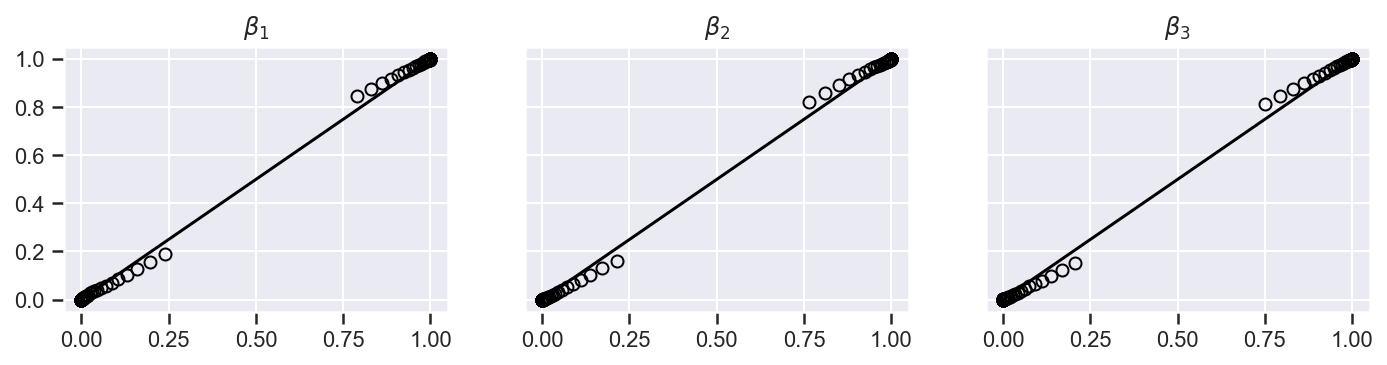

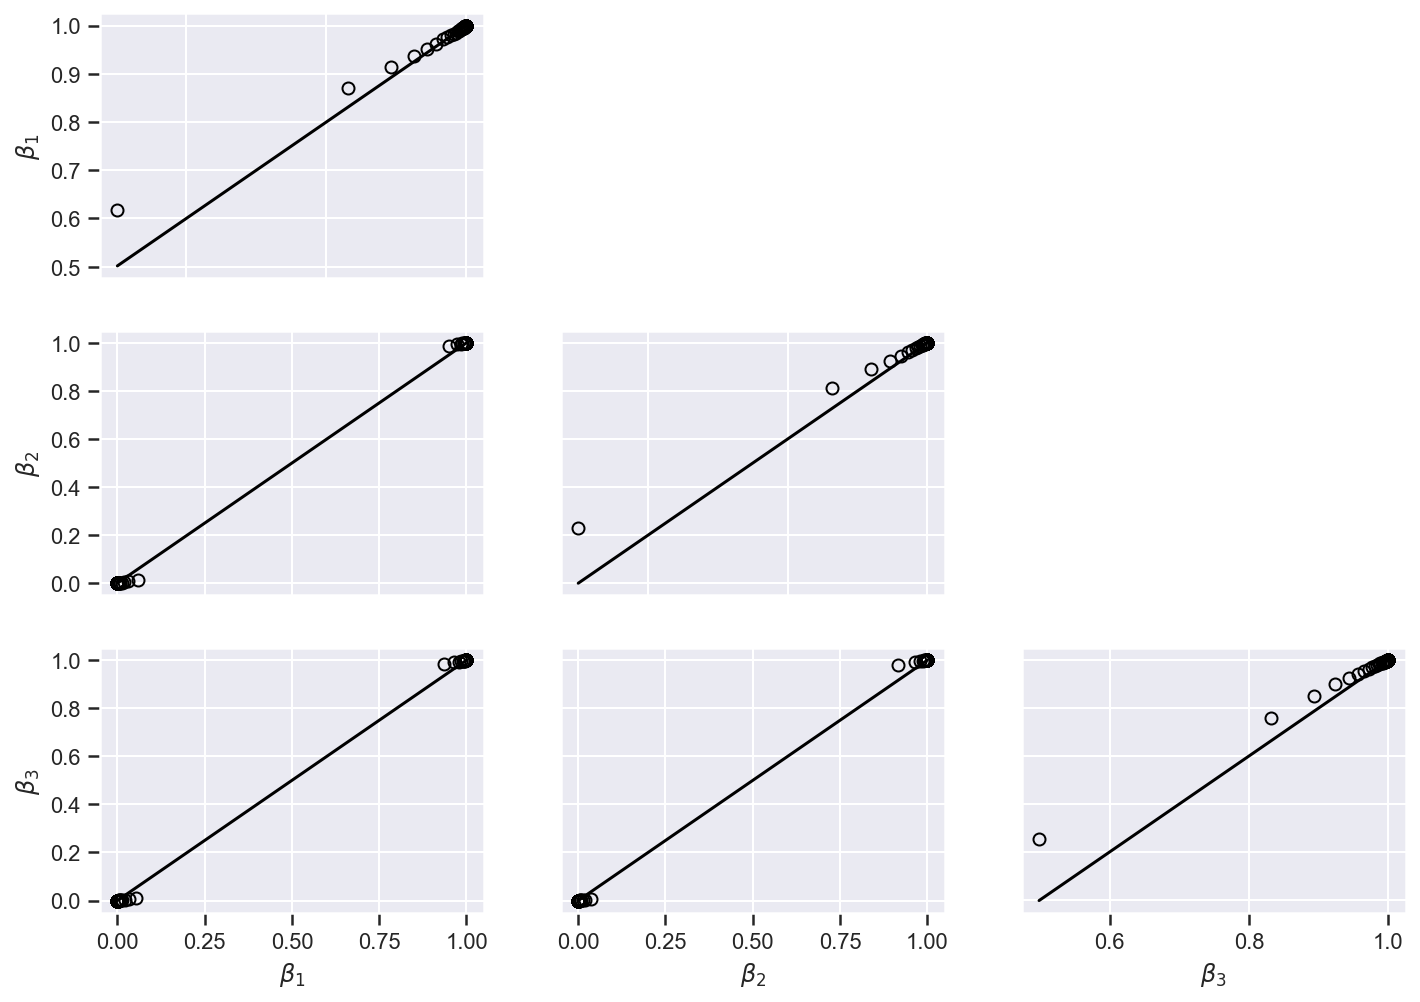

In [102]:
'''
Error 1: forget to include the transition probabilities when calculating the acceptance probabilities for the 'birth' and 'death' moves
'''
class bayes_lasso_sampler_error_1(bayes_lasso_sampler):
    def updateMH(self, j, k_proposal, gamma_proposal, beta_proposal, rng):
      diff_log_joint = self.log_joint(
          beta=beta_proposal, gamma=gamma_proposal, k=k_proposal) - self.log_joint()
      threshold = diff_log_joint

      log_u = onp.log(rng.uniform())
      if log_u <= threshold:
        self._k = k_proposal
        self._gamma = gamma_proposal
        self._beta = beta_proposal
      return log_u, threshold

bayes_lasso_error_1 = bayes_lasso_sampler_error_1(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_1.set_nthreads(nthreads)
sample_and_test(bayes_lasso_error_1)

Geweke test
{'result': array([ True, False, False, False, False,  True, False, False, False]), 'p_value': array([0.04065982, 0.21403363, 0.16970218, 0.38114428, 0.75220877,
       0.02559571, 0.86823904, 0.45284506, 0.31976313]), 'test_statistic': array([-2.04698234, -1.24255019,  1.37316138,  0.87578986, -0.31572826,
        2.23229133,  0.16589569,  0.75068034, -0.99494476]), 'critical_value': 1.959963984540054}
Test time: 28.321 seconds
Wild bootstrap MMD test
{'result': True, 'p_value': 0.0, 'test_statistic': 4.287857537963548, 'critical_value': 2.864845303437714}
Test time: 1.122 seconds
Backward MMD test
{'result': True, 'p_value': 0.016000000000000014, 'test_statistic': 0.6632174481637776, 'critical_value': 0.6520749302580953, 'kernel_width': 1.0}
Test time: 8.329 seconds


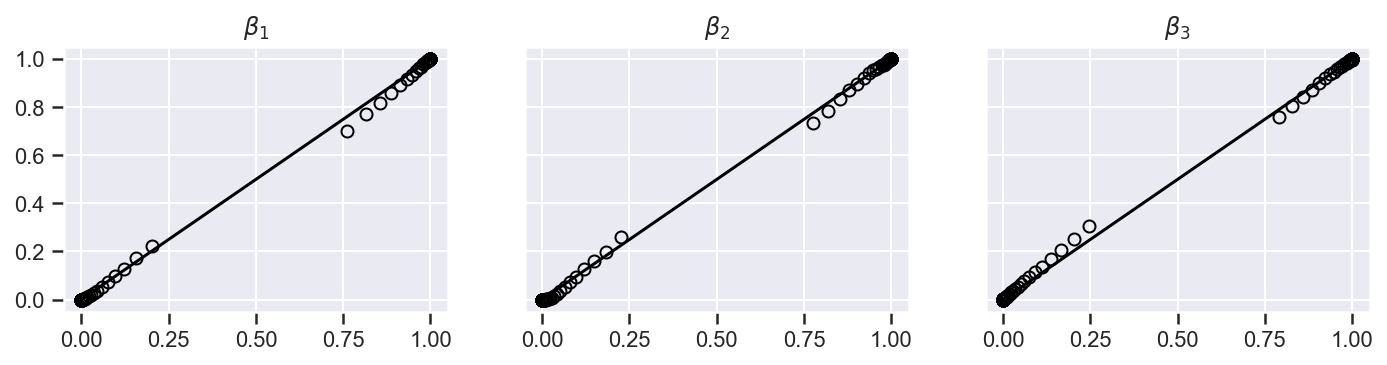

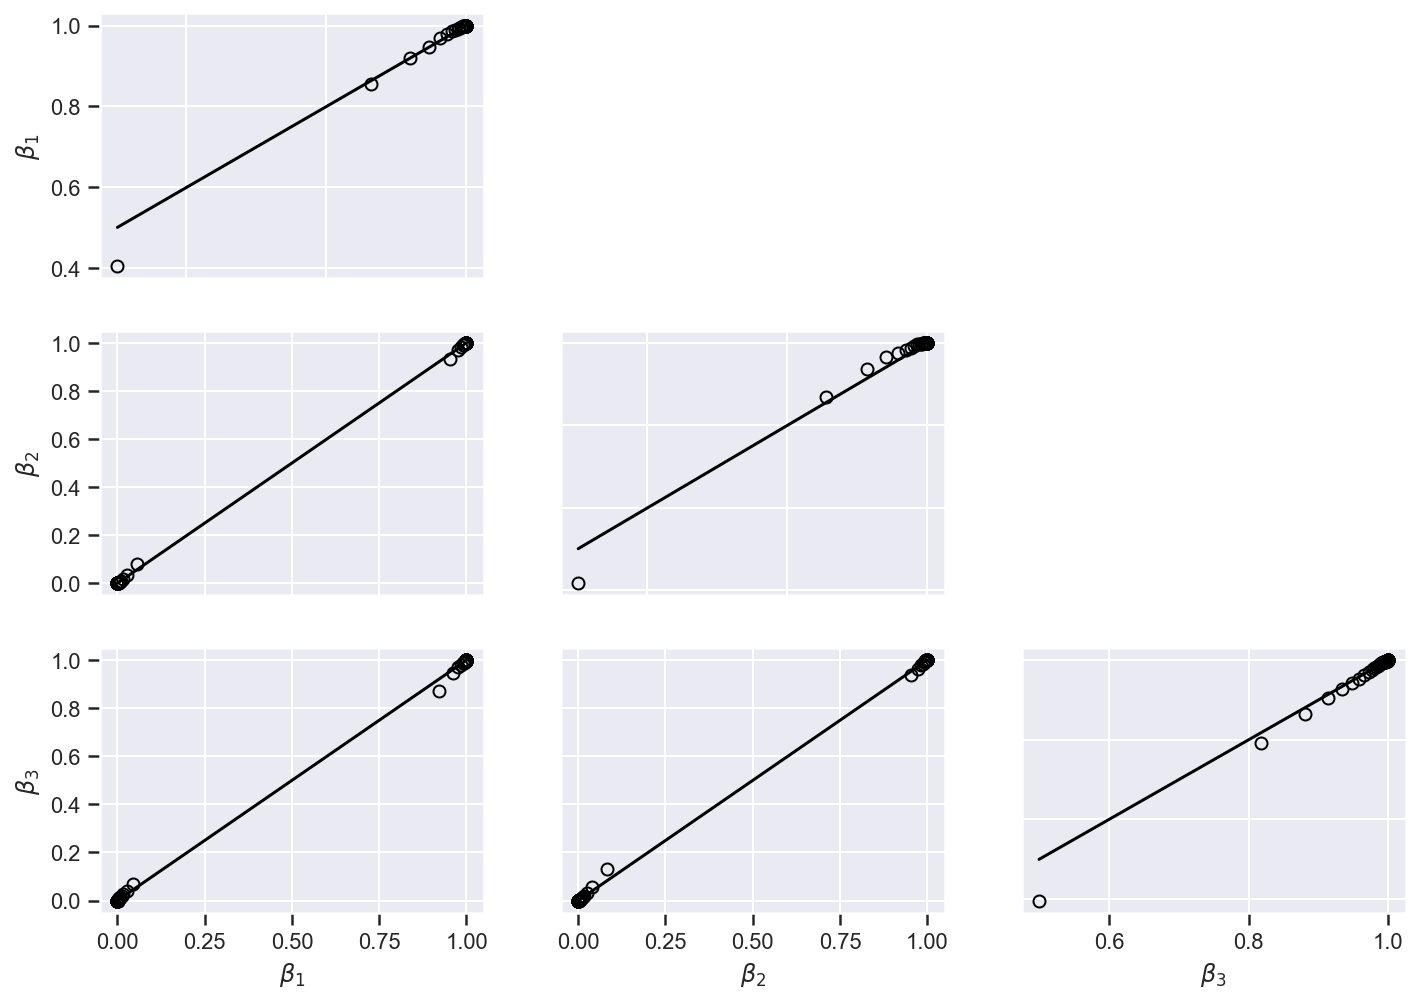

In [105]:
'''
Error 2: drop a '+1' in the log-prior calculation
'''
class bayes_lasso_sampler_error_2(bayes_lasso_sampler):
    def log_prior(self, beta=None, gamma=None, k=None):
      if beta is None:
        beta = self._beta
      if gamma is None:
        gamma = self._gamma
      if k is None:
        k = self._k
    #   return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k+1) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() # correct
      return - onp.log(comb(self._p, k)) - self._Lambda + k*onp.log(self._Lambda) - loggamma(k) + laplace.logpdf(x=beta[gamma, :], scale=self._tau).sum() # error

bayes_lasso_error_2 = bayes_lasso_sampler_error_2(n=n,p=p,Lambda=Lambda,tau=tau,sigma=sigma,epsilon_update=epsilon_update,epsilon_birth=epsilon_birth,mode='exact',epsilon_approx=0,batch_size=None)
bayes_lasso_error_1.set_nthreads(nthreads)
sample_and_test(bayes_lasso_error_2)

Both errors are detected by every test!